# Libs and parameter setting

In [1]:
import random
import numpy as np
import torch
import torch.utils.data as data
import utils.utils_image as util
import itertools
import os

from main_train_drunet_visuals import drunet_pipeline


from matplotlib import pyplot as plt

# Visuals train (patches and stuff)

In [53]:
n_channels = 1
n_channels_datasetload = 3
patch_size =  128
sigma = [0, 0]
sigma_min,  sigma_max =  sigma[0],  sigma[1]
num_patches_per_image = 20
dataroot_H = 'trainsets/web_images_train'
dataroot_L = 'trainsets/simulations'

# -------------------------------------
# get the path of H, return None if input is None
# -------------------------------------
paths_H = util.get_image_paths(dataroot_H)[:50]   # Edit: overfittear con las primeras 50 imagenes
paths_L = util.get_image_paths(dataroot_L)[:50]   # Edit: las primeras 9 imagenes pertenecen a test


listOfLists = [list(itertools.repeat(path,  num_patches_per_image)) for path in  paths_H]
paths_H = list(itertools.chain.from_iterable(listOfLists))

listOfLists = [list(itertools.repeat(path,  num_patches_per_image)) for path in  paths_L]
paths_L = list(itertools.chain.from_iterable(listOfLists))

In [54]:
indexes = np.random.randint(low=0, high=len(paths_H), size=10).astype('int16')
patches = []

In [55]:
for index in indexes:
    # -------------------------------------
    # get H and L image
    # -------------------------------------
    H_path = paths_H[index]
    L_path = paths_L[index]

    H_file, L_file = H_path.split('/')[-1], L_path.split('/')[-1]
    H_name, L_name = H_file.split('.')[0], L_file.split('.')[0]

    assert H_name==L_name, 'Both high and low quality images MUST have same name'

    img_H = util.imread_uint(H_path, n_channels_datasetload)       

    # L_path = H_path

    img_L = util.imread_uint(L_path, n_channels_datasetload)[:,:,:2]       

    # Get module of complex image, stretch and to uint8
    img_L = img_L.astype('float')
    img_L = np.abs(img_L[:,:,0]+1j*img_L[:,:,1])
    img_L = 255*(img_L - img_L.min())/(img_L.max() - img_L.min())
    img_L = img_L.astype('uint8')


    """
    # --------------------------------
    # get L/H/M patch pairs
    # --------------------------------
    """
    H, W = img_H.shape[:2]

    # ---------------------------------
    # randomly crop the patch
    # ---------------------------------
    rnd_h = random.randint(0, max(0, H - patch_size))
    rnd_w = random.randint(0, max(0, W - patch_size))

    # # Comment because using one only channel to train as ground-truth
    # patch_H = img_H[rnd_h:rnd_h + patch_size, rnd_w:rnd_w + patch_size, :]

    # Ground-truth as channels mean
    patch_H = np.mean(img_H[rnd_h:rnd_h + patch_size, rnd_w:rnd_w + patch_size, :],axis=2)

    # Get the patch from the simulation
    patch_L = img_L[rnd_h:rnd_h + patch_size, rnd_w:rnd_w + patch_size]

    # # Commented augmentation with rotating because of TMDS encoding

    # ---------------------------------
    # augmentation - flip, rotate
    # ---------------------------------
    # mode = random.randint(0, 7)
    # patch_L = util.augment_img(patch_H, mode=mode)

    # ---------------------------------
    # HWC to CHW, numpy(uint) to tensor
    # ---------------------------------
    img_H = util.uint2tensor3(patch_H)
    img_L = util.uint2tensor3(patch_L)

    # ---------------------------------
    # get noise level
    # ---------------------------------
    # noise_level = torch.FloatTensor([np.random.randint(self.sigma_min, sigma_max)])/255.0
    noise_level = torch.FloatTensor([np.random.uniform(sigma_min, sigma_max)])/255.0

    # ---------------------------------
    # add noise
    # ---------------------------------
    noise = torch.randn(img_L.size()).mul_(noise_level).float()
    img_L.add_(noise)

    patches.append(util.tensor2uint(img_H))
    patches.append(util.tensor2uint(img_L))


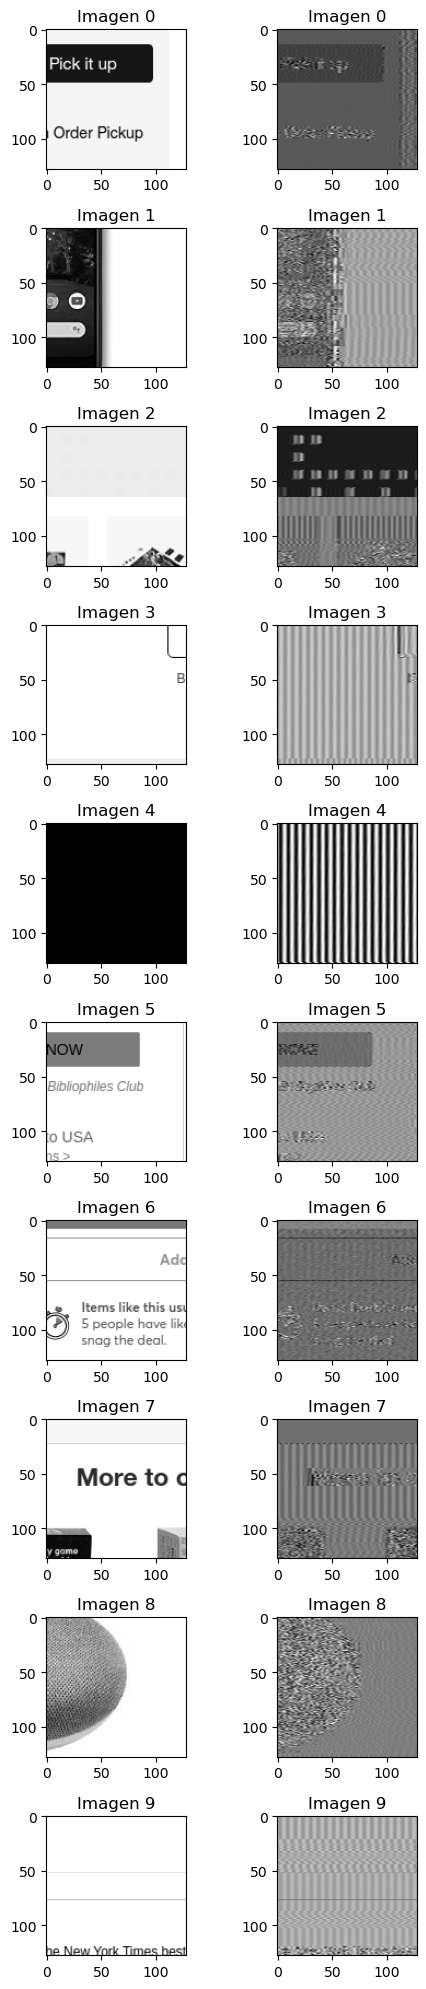

In [56]:
# Creamos la figura y los subplots
filas, columnas = len(patches)//2, 2
fig, axs = plt.subplots(filas, columnas, figsize=(5, 20))

# Recorremos las imágenes y las mostramos en los subplots
for i, ax in enumerate(axs.flatten()):
    if i < len(patches):
        ax.imshow(patches[i], cmap='gray')
        ax.set_title(f'Imagen {i//2}')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

# Test images

In [2]:
imgs = drunet_pipeline('options/visuals_drunet.json')


23-04-16 16:09:38.196 :   task: drunet
  model: plain
  gpu_ids: [0]
  scale: 0
  n_channels: 1
  n_channels_datasetload: 3
  sigma: [0, 50]
  sigma_test: 50
  path:[
    root: denoising
    pretrained_netG: denoising/drunet/models/15996_G.pth
    task: denoising/drunet
    log: denoising/drunet
    options: denoising/drunet/options
    models: denoising/drunet/models
    images: denoising/drunet/images
    pretrained_optimizerG: None
  ]
  datasets:[
    train:[
      name: train_dataset
      dataset_type: ffdnet
      dataroot_H: testsets/web_subset/ground_truth
      num_patches_per_image: 20
      dataroot_L: testsets/web_subset/simulations
      H_size: 128
      dataloader_shuffle: True
      dataloader_num_workers: 8
      dataloader_batch_size: 64
      phase: train
      scale: 0
      n_channels: 1
    ]
    test:[
      name: test_dataset
      dataset_type: ffdnet
      dataroot_H: testsets/web_subset/ground_truth
      dataroot_L: testsets/web_subset/simulations
      pha

export CUDA_VISIBLE_DEVICES=0
number of GPUs is: 1
LogHandlers setup!
Random seed: 4649
Dataset [DatasetFFDNet - test_dataset] is created.
Initialization method [orthogonal + uniform], gain is [0.20]
Training model [ModelPlain] is created.
Loading model for G [denoising/drunet/models/15996_G.pth] ...


23-04-16 16:09:39.705 : ---1-->  10534.png | PSNR = 11.07dB ; G_loss = 2.198e-01
23-04-16 16:09:39.995 : ---2-->  12460.png | PSNR = 19.93dB ; G_loss = 4.660e-02
23-04-16 16:09:40.284 : ---3-->    125.png | PSNR = 17.45dB ; G_loss = 1.179e-01
23-04-16 16:09:40.568 : ---4-->   4172.png | PSNR = 14.73dB ; G_loss = 1.027e-01
23-04-16 16:09:40.864 : ---5-->   5583.png | PSNR = 15.31dB ; G_loss = 1.405e-01
23-04-16 16:09:40.881 : Average PSNR : 15.70dB, Average loss : 1.255e-01



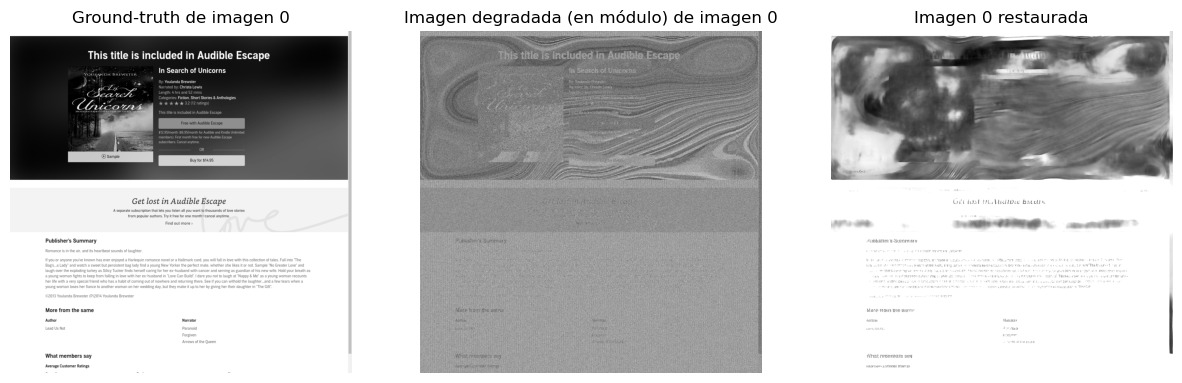

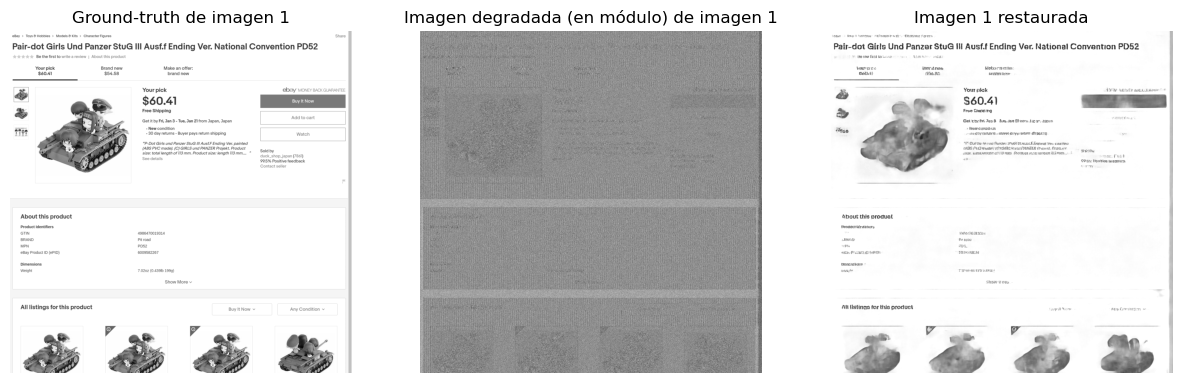

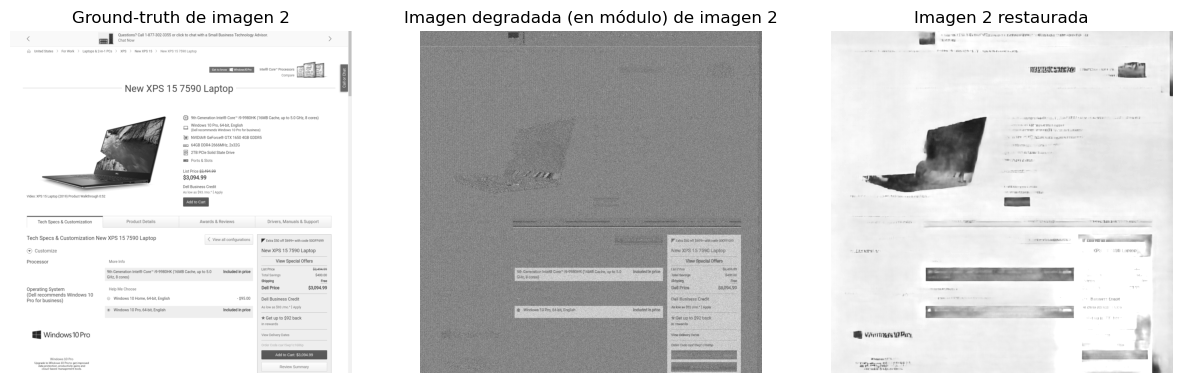

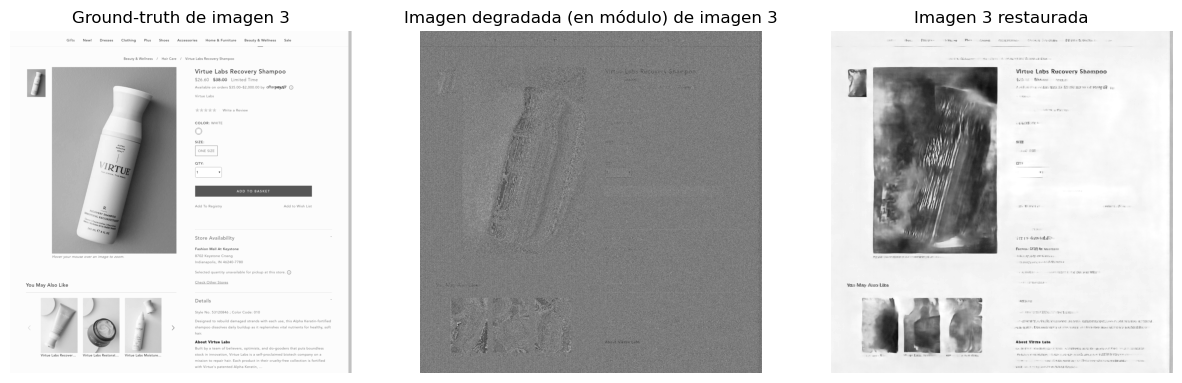

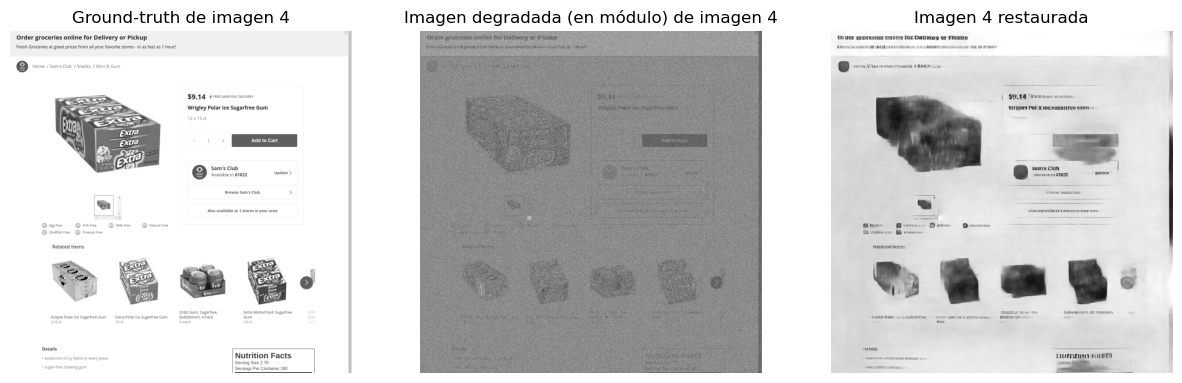

In [3]:
for ind,img in enumerate(imgs):

    H = img['H_vis']

    L = util.tensor2uint(img['L']).astype('float')
    L = np.abs(L[:,:,0] + 1j*L[:,:,1])
    L = (L - L.min())/(L.max() - L.min())

    E = img['E_vis']


    # Crea una figura y subfiguras utilizando Matplotlib
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

    # Muestra las imágenes en las subfiguras
    ax[0].imshow(H,cmap='gray')
    ax[0].axis("off")
    ax[0].set_title(f'Ground-truth de imagen {ind}')
    ax[1].imshow(L,cmap='gray')
    ax[1].axis("off")
    ax[1].set_title(f'Imagen degradada (en módulo) de imagen {ind}')
    ax[2].imshow(E,cmap='gray')
    ax[2].axis("off")
    ax[2].set_title(f'Imagen {ind} restaurada')

    # Muestra la figura
    plt.show()

In [8]:
def save_deeptempest_result(imgs_dict, save_path):

    file_name = imgs_dict['image_name']
    save_img_path = os.path.join(save_path, file_name)

    H = imgs_dict['H_vis']
    util.imsave(H, save_img_path+'_H.png')

    L = util.tensor2uint(imgs_dict['L']).astype('float')
    L = np.abs(L[:,:,0] + 1j*L[:,:,1])
    L = 255*(L - L.min())/(L.max() - L.min())
    util.imsave(L, save_img_path+'_L.png')

    E = imgs_dict['E_vis']

    util.imsave(E, save_img_path+'_E.png')

In [9]:
######################################################################
### Save results (given by a selected index) in the specified path ###
######################################################################
save_ind = 1 # COMPLETE INDEX NUMBER

save_path = 'testsets/web_subset/visuals' # COMPLETE SAVING PATH

save_deeptempest_result(imgs[save_ind], save_path)